In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt

In [2]:
pyro.enable_validation(True)

In [3]:
N = 1000
D = 2

In [4]:
def dgp(X):
#def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K = 2
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        #cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [5]:
trace = pyro.poutine.trace(dgp).get_trace(torch.zeros(N,D))
logp = trace.log_prob_sum()
true_variables = [trace.nodes[name]["value"] for name in trace.stochastic_nodes]
trace.stochastic_nodes

['D', 'loc', 'scale', 'K', 'cov_factor', 'N', 'obs']

In [6]:
logp

tensor(-5612.5278)

In [7]:
_,true_loc,true_scale,_,true_cov_factor,_,data = true_variables

In [8]:
K = 1
#initial_hyperparameters = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
initial_hyperparameters = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)

In [9]:
#def model(X):
def model(X, hyperparameters = initial_hyperparameters):
    N, D = X.shape
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D):
        loc = pyro.sample('loc', dst.Normal(locloc, locscale))
        cov_diag = pyro.sample('scale', dst.LogNormal(scaleloc, scalescale))
        with pyro.plate('K', K):
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc,cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
    with pyro.plate('N', N):
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return X

In [10]:
def guide(X, hyperparameters):
#def guide(X):
    #K = 2
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    with pyro.plate('D', D, dim=-1):
        # get initial parameter values from parent
        # define parameters, clone initial parameter values from supplied hyperparameters, to avoid updating them
        loc_loc = pyro.param('loc_loc', locloc)
        loc_scale = pyro.param('loc_scale', locscale, constraint=constraints.positive)
        cov_diag_loc = pyro.param('scale_loc', scaleloc)
        cov_diag_scale = pyro.param('scale_scale', scalescale, constraint=constraints.positive)
        # sample variables
        loc = pyro.sample('loc', dst.Normal(loc_loc,loc_scale))
        with pyro.plate('K', K, dim=-2):
            cov_factor_loc = pyro.param('cov_factor_loc_{}'.format(K), cov_factor_loc)
            cov_factor_scale = pyro.param('cov_factor_scale_{}'.format(K), cov_factor_scale, constraint=constraints.positive)
            cov_factor = pyro.sample('cov_factor', dst.Normal(cov_factor_loc, cov_factor_scale))
        cov_factor = cov_factor.transpose(0,1)
        cov_diag = pyro.sample('scale', dst.LogNormal(cov_diag_loc, cov_diag_scale))
    return loc, cov_factor, cov_diag

In [11]:
track_params = True
def per_param_callable(module_name, param_name):
    #return {"lr": 0.01, "betas": (0.9, 0.8)} # too much momentum slows down learning apparently
    #return {"lr": 0.005, "betas": (0.9, 0.9)} # too much momentum slows down learning apparently
    return {"lr": 0.01, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    #return {"lr": 0.001, 'betas': [0.9, 0.99]}
    #return {"lr": 0.01, 'betas': [0.9, 0.99]}
    #return {"lr": 0.1, 'betas': [0.9, 0.99]}

In [12]:
pyro.clear_param_store()

In [13]:
conditioned_model = pyro.condition(model, data = {'obs': data})
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.99 })
elbo = Trace_ELBO()
svi = SVI(conditioned_model, guide, scheduler, loss=elbo, num_samples=50)

In [14]:
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
# take one svi step to populate the param store
loss = svi.step(data, initial_hyperparameters)
#loss = svi.step(data, initial_hyperparameters)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [15]:
# if the dgp is contained within the model:
# check that the loss is small on true parameters, i.e. parameters where means are the true variables, and scales are 0.01

#params = pyro.get_param_store()
#scales = 0.0001
#true_params = (true_loc,scales*torch.ones_like(params.get_param('loc_scale')),\
#               true_scale,scales*torch.ones_like(params.get_param('scale_scale')),\
#              true_cov_factor,scales*torch.ones_like(params.get_param('cov_factor_scale_1')))
#for name,new_value in zip(params.get_all_param_names(),true_params):
#    params.replace_param(name,new_value,params.get_param(name))
#    
#print(true_params)
#print(svi.loss(conditioned_model, guide, data))

In [16]:
# check that the loss is big on random parameters
params = pyro.get_param_store()
true_params = (torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D)))
for name,new_value in zip(params.get_all_param_names(),true_params):
    params.replace_param(name,new_value,params.get_param(name))

print(true_params)
print(svi.loss(conditioned_model, guide, data, initial_hyperparameters))
# check loss on initial parameters
params = pyro.get_param_store()
true_params = (torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D)*10)
for name,new_value in zip(params.get_all_param_names(),true_params):
    params.replace_param(name,new_value,params.get_param(name))
    
print(true_params)
print(svi.loss(conditioned_model, guide, data, initial_hyperparameters))

(tensor([1.0668, 0.2808], requires_grad=True), tensor([1.0532, 1.4398]), tensor([ 0.9413, -0.1442], requires_grad=True), tensor([0.3664, 0.1223]), tensor([[0.4885, 1.1400]], requires_grad=True), tensor([[0.3745, 0.9917]]))
19546.264546394348
(tensor([0., 0.], requires_grad=True), tensor([1., 1.]), tensor([0., 0.], requires_grad=True), tensor([1., 1.]), tensor([[0., 0.]], requires_grad=True), tensor([[10., 10.]]))
6945.843935966492


In [17]:
# optimize
for i in range(20000):
    loss = svi.step(data, initial_hyperparameters)
    if i % 100:
        print('.', end='')
    else:
        scheduler.step()
        state = scheduler.get_state()['loc_loc']
        print('\nSetting lr to {}'.format(state['base_lrs'][0]*state['gamma']**state['last_epoch']), end='')
        print('\n', end='')
    #loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        #print('.' if i % 100 else '\n', end='')
params = pyro.get_param_store()


Setting lr to 0.0099
...................................................................................................
Setting lr to 0.009801
...................................................................................................
Setting lr to 0.00970299
...................................................................................................
Setting lr to 0.0096059601
...................................................................................................
Setting lr to 0.009509900499
...................................................................................................
Setting lr to 0.00941480149401
...................................................................................................
Setting lr to 0.0093206534790699
...................................................................................................
Setting lr to 0.0092274469442792
.............................................................................

...................................................................................................
Setting lr to 0.005309055429551132
...................................................................................................
Setting lr to 0.00525596487525562
...................................................................................................
Setting lr to 0.005203405226503064
...................................................................................................
Setting lr to 0.005151371174238033
...................................................................................................
Setting lr to 0.005099857462495653
...................................................................................................
Setting lr to 0.005048858887870696
...................................................................................................
Setting lr to 0.004998370298991989
........................................................

...................................................................................................
Setting lr to 0.002904884943099638
...................................................................................................
Setting lr to 0.002875836093668641
...................................................................................................
Setting lr to 0.0028470777327319545
...................................................................................................
Setting lr to 0.002818606955404635
...................................................................................................
Setting lr to 0.0027904208858505887
...................................................................................................
Setting lr to 0.002762516676992083
...................................................................................................
Setting lr to 0.0027348915102221624
....................................................

...................................................................................................
Setting lr to 0.001589427091997875
...................................................................................................
Setting lr to 0.0015735328210778963
...................................................................................................
Setting lr to 0.0015577974928671174
...................................................................................................
Setting lr to 0.001542219517938446
...................................................................................................
Setting lr to 0.0015267973227590618
...................................................................................................
Setting lr to 0.001511529349531471
...................................................................................................
Setting lr to 0.0014964140560361563
...................................................

In [18]:
list(pyro.get_param_store().items())

[('loc_loc', tensor([ 1.7053, -0.4848], requires_grad=True)),
 ('loc_scale', tensor([0.0819, 0.1091], grad_fn=<AddBackward0>)),
 ('scale_loc', tensor([-0.6199,  2.4445], requires_grad=True)),
 ('scale_scale', tensor([0.0954, 0.0457], grad_fn=<AddBackward0>)),
 ('cov_factor_loc_1', tensor([[ 4.3325, -4.7523]], requires_grad=True)),
 ('cov_factor_scale_1', tensor([[0.0712, 0.1032]], grad_fn=<AddBackward0>))]

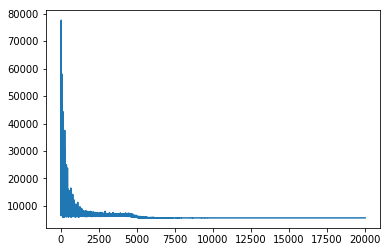

In [19]:
plt.plot(losses)

In [20]:
gradient_norms.keys()

dict_keys(['cov_factor_loc_1', 'scale_loc', 'loc_loc'])

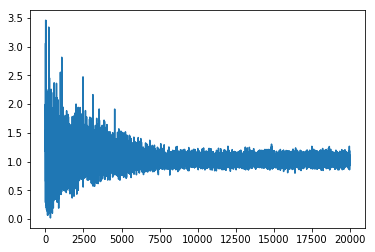

In [21]:
plt.plot(gradient_norms['loc_loc'])

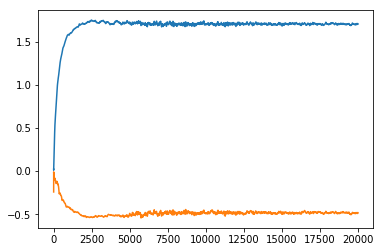

In [22]:
plt.plot(param_history['loc_loc'].detach().numpy())

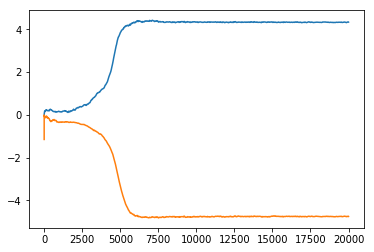

In [23]:
plt.plot(param_history['cov_factor_loc_1'].reshape(-1,K*D).detach().numpy())

In [24]:
# MAP
est_cov_factor = pyro.param('cov_factor_loc_{}'.format(K))
est_diag = dst.LogNormal(params.get_param('scale_loc'),params.get_param('scale_scale')).mean

In [25]:
# EXPECTED COVARIANCE AND CORRELATION
#true_total_cov = true_cov_factor.transpose(0,1) @ true_cov_factor + torch.diag(true_scale)
true_total_cov = true_cov_factor @ true_cov_factor.transpose(0,1) + torch.diag(true_scale)
print(true_total_cov)
invsds = torch.diag(torch.sqrt(torch.diag(true_total_cov))).inverse()
# expected correlation matrix
torch.matmul(invsds,torch.matmul(true_total_cov,invsds))

tensor([[ 21.0503, -23.8669],
        [-23.8669,  38.7888]])


tensor([[ 1.0000, -0.8352],
        [-0.8352,  1.0000]])

In [26]:
# EMPIRICAL COVARIANCE AND CORRELATION
print(np.cov(data.detach().numpy().T))
#empirical correlation matrix
np.corrcoef(data.detach().numpy().T)

[[ 20.64103108 -22.84418104]
 [-22.84418104  37.44506297]]


array([[ 1.        , -0.82169873],
       [-0.82169873,  1.        ]])

In [29]:
# MAP COVARIANCE AND CORRELATION
est_total_cov = est_cov_factor.transpose(0,1) @ est_cov_factor + torch.diag(est_diag)
print(est_total_cov)
est_invsds = torch.diag(torch.sqrt(torch.diag(est_total_cov))).inverse()
est_corr_mat = torch.matmul(est_invsds,torch.matmul(est_total_cov,est_invsds))
print(est_corr_mat)

tensor([[ 19.3107, -20.5893],
        [-20.5893,  34.1212]], grad_fn=<AddBackward0>)
tensor([[ 1.0000, -0.8021],
        [-0.8021,  1.0000]], grad_fn=<MmBackward>)


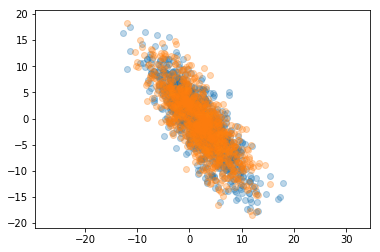

In [30]:
from tracepredictive import *

trace_pred = TracePredictive(model, svi, num_samples=1000).run(data[:,:500], initial_hyperparameters)
random_idx = np.random.randint(1000)
predictive_dst_sample = [torch.unsqueeze(trace.nodes['obs']['value'][random_idx,:],dim=0) for trace in trace_pred.exec_traces]
predictive_dst_sample = torch.cat(predictive_dst_sample, dim=0)

plt.scatter(*data.detach().numpy().T,alpha=.3)
plt.scatter(*predictive_dst_sample.detach().numpy().T,alpha=.3);
plt.axis('equal');

In [33]:
true_cov_factor.transpose(0,1)

tensor([[ 1.6379, -4.6461],
        [-3.9878,  4.0768]])

In [34]:
est_cov_factor

tensor([[ 4.3325, -4.7523]], requires_grad=True)